<a href="https://colab.research.google.com/github/fpinell/mlsa/blob/main/notebooks/transformers_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter10()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *
from plots.chapter10 import *

Finished!


In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms.v2 import Compose, Normalize, Pad

from data_generation.square_sequences import generate_sequences
from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 9
from seq2seq import PositionalEncoding, subsequent_mask, EncoderDecoderSelfAttn

In [36]:
import numpy as np
import random

# Function to generate synthetic GPS trajectories with timestamps in the Florence area
def generate_gps_trajectories_with_timestamps(num_trajectories=10, sequence_length=5, predict_length=3, start_time="2024-01-01 08:00:00", time_interval=15):
    from datetime import datetime, timedelta

    # Coordinates for the center of Florence, Italy
    florence_center_lat = 43.7696
    florence_center_lon = 11.2558
    max_offset = 0.01  # Small offset for realistic variation around the center point

    sequences = []
    next_points = []

    for _ in range(num_trajectories):
        # Initialize starting point and time near Florence center
        trajectory = []
        current_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")

        # Generate initial trajectory points with timestamps
        for _ in range(sequence_length):
            point = [
                florence_center_lat + random.uniform(-max_offset, max_offset),   # Latitude
                florence_center_lon + random.uniform(-max_offset, max_offset),   # Longitude
                current_time.timestamp()                                         # Timestamp in seconds
            ]
            trajectory.append(point)
            current_time += timedelta(minutes=time_interval)  # Increment time by time_interval

        # Generate future points (predictions) with timestamps
        future_points = []
        for _ in range(predict_length):
            last_point = trajectory[-1] if not future_points else future_points[-1]
            new_point = [
                last_point[0] + random.uniform(-0.001, 0.001),  # Small latitude step
                last_point[1] + random.uniform(-0.001, 0.001),  # Small longitude step
                last_point[2] + (time_interval * 60)            # Increment time by time_interval in seconds
            ]
            future_points.append(new_point)

        # Append trajectory (input) and future points (target) to lists
        sequences.append(trajectory)
        next_points.append(future_points)

    # Convert to numpy arrays for use in models
    sequences_np = np.array(sequences)
    next_points_np = np.array(next_points)

    return sequences_np, next_points_np

# Generate sample Florence GPS trajectories with timestamps
train_gps_sequences_with_time_np, train_gps_next_points_with_time_np = generate_gps_trajectories_with_timestamps(1000)
valid_gps_sequences_with_time_np, valid_gps_next_points_with_time_np = generate_gps_trajectories_with_timestamps(100)
test_gps_sequences_with_time_np, test_gps_next_points_with_time_np = generate_gps_trajectories_with_timestamps(20)




In [37]:
from sklearn.preprocessing import MinMaxScaler
full_train_sequences = np.concatenate([train_gps_sequences_with_time_np.reshape(-1, 3), train_gps_next_points_with_time_np.reshape(-1, 3)], axis=0)


scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(full_train_sequences)
full_train_sequences_scaled = scaler.transform(full_train_sequences)
train_target_scaled = scaler.transform(train_gps_next_points_with_time_np.reshape(-1,3))

valid_source_sequences_scaled = scaler.transform(valid_gps_sequences_with_time_np.reshape(-1,3))
valid_target_sequences_scaled = scaler.transform(valid_gps_next_points_with_time_np.reshape(-1,3))

In [38]:
valid_source_sequences_scaled[:10]

array([[ 0.86356427, -0.75987502, -1.        ],
       [ 0.50607633, -0.80043065, -0.71428571],
       [ 0.21425036, -0.0067599 , -0.42857143],
       [ 0.5453014 , -0.35944644, -0.14285714],
       [ 0.58272209,  0.54569784,  0.14285714],
       [-0.47696318,  0.146056  , -1.        ],
       [ 0.3394345 ,  0.53180096, -0.71428571],
       [-0.16892952,  0.0877229 , -0.42857143],
       [-0.31929893, -0.16383776, -0.14285714],
       [-0.16929406, -0.70150254,  0.14285714]])

In [39]:

class GPSDataset(torch.utils.data.Dataset):
    def __init__(self, full_sequences):
        # Here, `full_sequences` should be an array with both source and target points in each sequence
        self.full_sequences = torch.tensor(full_sequences, dtype=torch.float32)

    def __len__(self):
        return len(self.full_sequences)

    def __getitem__(self, idx):
        return self.full_sequences[idx]

In [40]:
class TransformerModel(nn.Module):
    def __init__(self, transformer, input_len, target_len, n_features):
        super().__init__()
        self.transf = transformer
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.transf.generate_square_subsequent_mask(self.target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, self.transf.d_model)
        self.linear = nn.Linear(self.transf.d_model, n_features)

        max_len = max(self.input_len, self.target_len)
        self.pe = PositionalEncoding(max_len, self.transf.d_model)
        self.norm = nn.LayerNorm(self.transf.d_model)

    def preprocess(self, seq):
        seq_proj = self.proj(seq)
        seq_enc = self.pe(seq_proj)
        return self.norm(seq_enc)

    def encode_decode(self, source, target, source_mask=None, target_mask=None):
        # Projections
        src = self.preprocess(source)
        tgt = self.preprocess(target)

        out = self.transf(src, tgt,
                          src_key_padding_mask=source_mask,
                          tgt_mask=target_mask)

        # Linear
        out = self.linear(out) # N, L, F
        return out

    def predict(self, source_seq, source_mask=None):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.encode_decode(source_seq, inputs,
                                     source_mask=source_mask,
                                     target_mask=self.trg_masks[:i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = out[:, 1:, :]
        return outputs

    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X)
        source_seq = X[:, :self.input_len, :]

        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.encode_decode(source_seq, shifted_target_seq,
                                         source_mask=source_mask,
                                         target_mask=self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)

        return outputs


In [42]:
# Initialize hyperparameters
input_len = 5       # Length of the input sequence (e.g., the first 5 GPS points)
target_len = 3      # Number of points to predict
n_features = 3      # Number of features per GPS point (latitude, longitude, timestamp)
d_model = 64        # Model dimension for the transformer

# Initialize the transformer and model
transformer = nn.Transformer(d_model=d_model, nhead=4, num_encoder_layers=3, num_decoder_layers=3,batch_first=True)
model = TransformerModel(transformer, input_len=input_len, target_len=target_len, n_features=n_features)

# Scale GPS data (Assume gps_sequences_np and gps_next_points_np are already generated and scaled)
train_data = TensorDataset(torch.tensor(full_train_sequences_scaled.reshape(1000,8,3), dtype=torch.float32),
                           torch.tensor(train_target_scaled.reshape(1000,3,3), dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

valid_data = TensorDataset(torch.tensor(valid_source_sequences_scaled.reshape(100,5,3), dtype=torch.float32),
                           torch.tensor(valid_target_sequences_scaled.reshape(100,3,3), dtype=torch.float32))

valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [43]:
sbs_seq_transformer = StepByStep(model, criterion, optimizer)
sbs_seq_transformer.set_loaders(train_loader,valid_loader)
sbs_seq_transformer.train(50)

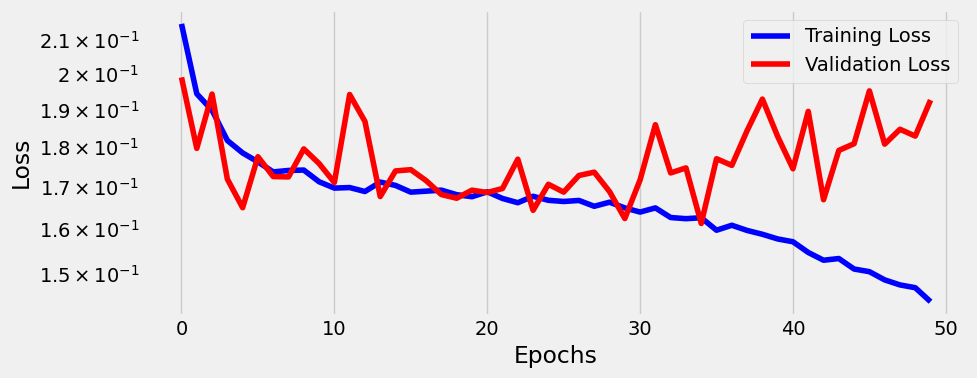

In [44]:
fig = sbs_seq_transformer.plot_losses()

In [45]:
t = torch.tensor(valid_source_sequences_scaled[:25].reshape(5,5,3), dtype=torch.float32)
t,t.shape

(tensor([[[ 0.8636, -0.7599, -1.0000],
          [ 0.5061, -0.8004, -0.7143],
          [ 0.2143, -0.0068, -0.4286],
          [ 0.5453, -0.3594, -0.1429],
          [ 0.5827,  0.5457,  0.1429]],
 
         [[-0.4770,  0.1461, -1.0000],
          [ 0.3394,  0.5318, -0.7143],
          [-0.1689,  0.0877, -0.4286],
          [-0.3193, -0.1638, -0.1429],
          [-0.1693, -0.7015,  0.1429]],
 
         [[-0.5180, -0.3168, -1.0000],
          [-0.5032,  0.3993, -0.7143],
          [ 0.8125,  0.2832, -0.4286],
          [ 0.1883,  0.1332, -0.1429],
          [ 0.7201,  0.8461,  0.1429]],
 
         [[ 0.8477,  0.2670, -1.0000],
          [-0.7662, -0.0665, -0.7143],
          [ 0.0548,  0.5424, -0.4286],
          [ 0.0968, -0.5772, -0.1429],
          [-0.6610, -0.7786,  0.1429]],
 
         [[ 0.7518,  0.7440, -1.0000],
          [ 0.7733,  0.5068, -0.7143],
          [-0.4156,  0.3085, -0.4286],
          [ 0.4498,  0.1137, -0.1429],
          [ 0.1889,  0.6549,  0.1429]]]),
 torch.Siz

In [46]:
with torch.no_grad():
  model.eval()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  t = t.to(device)
  p = model(t)
  pred = scaler.inverse_transform(p.detach().cpu().numpy().reshape(-1,3))

In [47]:
pred[:10][0],pred[:10][1]

(array([4.3770317e+01, 1.1255978e+01, 1.7041006e+09], dtype=float32),
 array([4.3770832e+01, 1.1255675e+01, 1.7041016e+09], dtype=float32))

0
[43.77706114 43.77727336 43.77755112] [11.26202423 11.26300363 11.26329968]
[43.770317 43.770832 43.772106] [11.255978 11.255675 11.254588]


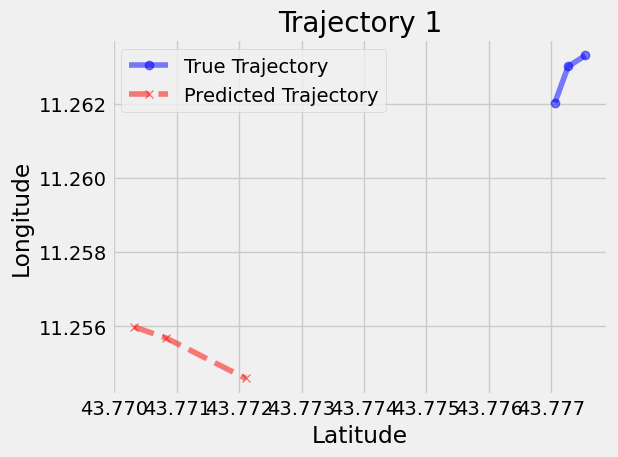

1
[43.76667265 43.76577086 43.7653032 ] [11.24736485 11.24732463 11.24679123]
[43.770554 43.769478 43.768806] [11.253929  11.2537155 11.251897 ]


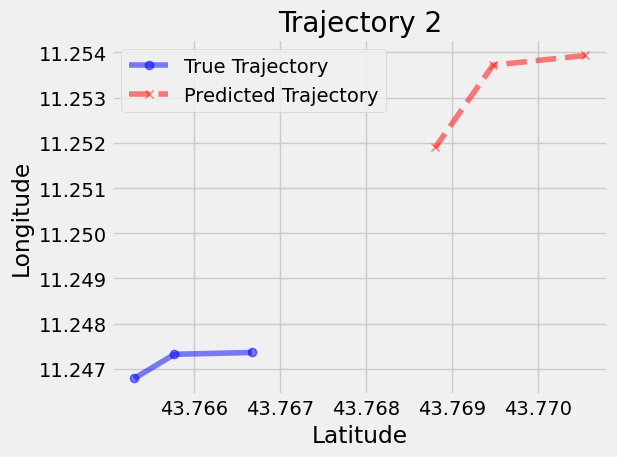

2
[43.77773153 43.7781545  43.77748479] [11.26474273 11.26556487 11.26542645]
[43.7688  43.76892 43.76946] [11.255272 11.254748 11.25277 ]


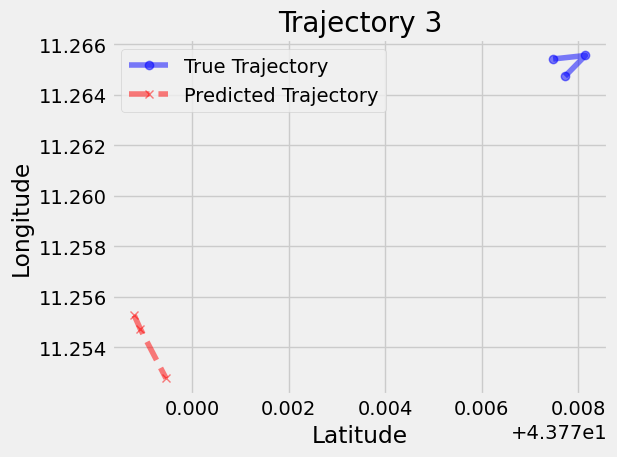

3
[43.76069717 43.75975203 43.76000757] [11.24722917 11.24783566 11.24702582]
[43.76773  43.76956  43.768753] [11.257071 11.258075 11.256317]


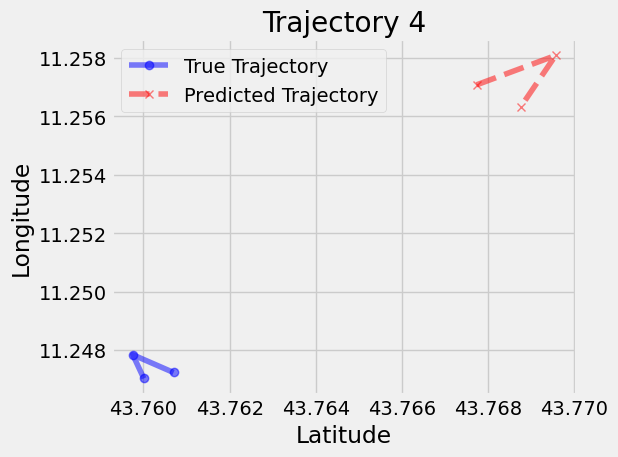

4
[43.77206956 43.77136277 43.77231479] [11.26339618 11.26262009 11.26354513]
[43.77032  43.770805 43.77179 ] [11.25632   11.25609   11.2553425]


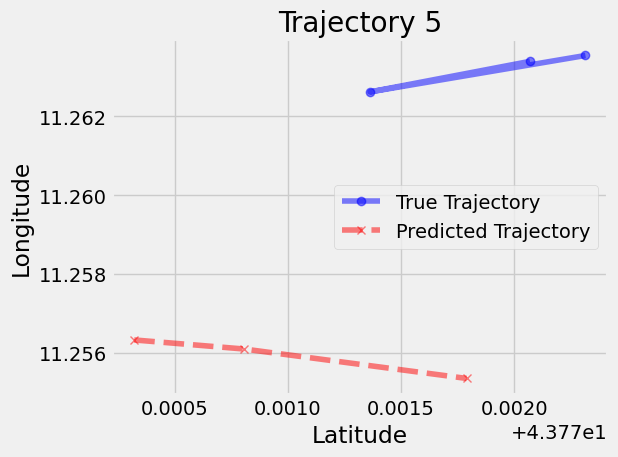

In [48]:
num_trajectories =  pred.shape[0]

for i in range(5):
  print(i)
  pred_lat_lon = pred.reshape(5,3,3)[i, :, :2]  # Predicted latitude and longitude
  true_lat_lon = valid_gps_next_points_with_time_np[:5][i, :, :2]  # True latitude and longitude

  print(true_lat_lon[:, 0], true_lat_lon[:, 1])
  print(pred_lat_lon[:, 0], pred_lat_lon[:, 1])
  plt.plot(true_lat_lon[:, 0], true_lat_lon[:, 1], 'o-', label='True Trajectory', color='blue',alpha=0.5)
  plt.plot(pred_lat_lon[:, 0], pred_lat_lon[:, 1], 'x--', label='Predicted Trajectory', color='red',alpha=0.5)

  # Set plot details
  plt.title(f'Trajectory {i + 1}')
  plt.xlabel('Latitude')
  plt.ylabel('Longitude')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

In [21]:
pred.reshape(5,3,3),valid_gps_next_points_with_time_np[:5]

(array([[[4.37706070e+01, 1.12541275e+01, 1.70410061e+09],
         [4.37698708e+01, 1.12542486e+01, 1.70410099e+09],
         [4.37695580e+01, 1.12542973e+01, 1.70410112e+09]],
 
        [[4.37668457e+01, 1.12555180e+01, 1.70410074e+09],
         [4.37664566e+01, 1.12553959e+01, 1.70410112e+09],
         [4.37663155e+01, 1.12554922e+01, 1.70410138e+09]],
 
        [[4.37685318e+01, 1.12562609e+01, 1.70410099e+09],
         [4.37695122e+01, 1.12550840e+01, 1.70410138e+09],
         [4.37696762e+01, 1.12548285e+01, 1.70410163e+09]],
 
        [[4.37610359e+01, 1.12563820e+01, 1.70410099e+09],
         [4.37616539e+01, 1.12570992e+01, 1.70410112e+09],
         [4.37619095e+01, 1.12574739e+01, 1.70410138e+09]],
 
        [[4.37735901e+01, 1.12564030e+01, 1.70410099e+09],
         [4.37738419e+01, 1.12585535e+01, 1.70410176e+09],
         [4.37730637e+01, 1.12585640e+01, 1.70410202e+09]]], dtype=float32),
 array([[[4.37729664e+01, 1.12545739e+01, 1.70410050e+09],
         [4.37727140e+01, 

In [34]:
# Initialize hyperparameters
input_len = 5       # Length of the input sequence (e.g., the first 5 GPS points)
target_len = 3      # Number of points to predict
n_features = 3      # Number of features per GPS point (latitude, longitude, timestamp)
d_model = 12        # Model dimension for the transformer

# Initialize the transformer and model
transformer = nn.Transformer(d_model=d_model, nhead=3, num_encoder_layers=2, num_decoder_layers=2, batch_first=True)
model = TransformerModel(transformer, input_len=input_len, target_len=target_len, n_features=n_features)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [35]:
# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (src, tgt) in enumerate(train_loader):
        optimizer.zero_grad()
        src = src.to(device)
        tgt = tgt.to(device)
        # Forward pass
        outputs = model(src)  # Model automatically switches between training and inference modes
        loss = criterion(outputs, tgt)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

print("Training complete.")


Epoch [1/50], Loss: 0.3064
Epoch [2/50], Loss: 0.2416
Epoch [3/50], Loss: 0.2309
Epoch [4/50], Loss: 0.2216
Epoch [5/50], Loss: 0.2207
Epoch [6/50], Loss: 0.2234
Epoch [7/50], Loss: 0.2258
Epoch [8/50], Loss: 0.2193
Epoch [9/50], Loss: 0.2226
Epoch [10/50], Loss: 0.2137
Epoch [11/50], Loss: 0.2173
Epoch [12/50], Loss: 0.2162
Epoch [13/50], Loss: 0.2204
Epoch [14/50], Loss: 0.2072
Epoch [15/50], Loss: 0.2102
Epoch [16/50], Loss: 0.2085
Epoch [17/50], Loss: 0.2121
Epoch [18/50], Loss: 0.2094
Epoch [19/50], Loss: 0.2038
Epoch [20/50], Loss: 0.2109
Epoch [21/50], Loss: 0.2097
Epoch [22/50], Loss: 0.2052
Epoch [23/50], Loss: 0.2064
Epoch [24/50], Loss: 0.2117
Epoch [25/50], Loss: 0.2026
Epoch [26/50], Loss: 0.2037
Epoch [27/50], Loss: 0.2004
Epoch [28/50], Loss: 0.1964
Epoch [29/50], Loss: 0.1943
Epoch [30/50], Loss: 0.2026
Epoch [31/50], Loss: 0.1950
Epoch [32/50], Loss: 0.1976
Epoch [33/50], Loss: 0.1914
Epoch [34/50], Loss: 0.1877
Epoch [35/50], Loss: 0.1925
Epoch [36/50], Loss: 0.1862
E